# Proyecto Integrador: Análisis Supervisado
**Estudiantes:** 
- Jonathan David Ayala Garcia
- Hernandez Ramirez Adrian
- Andres Isai Acosta Guerra
- Jaime Castañeda Rodriguez

**Asignatura:** Extracción de Conocimiento en Bases de Datos  
**Unidad:** III - Análisis Supervisado  
**Docente:** Ing. Maximiliano Carsi Castrejón  

## Descripción del Dataset
Este proyecto utiliza un dataset preprocesado sobre residuos peligrosos, con datos anuales por entidad federativa, tipo de residuo, subsector y generación estimada. El objetivo es aplicar técnicas de análisis supervisado para predecir la generación de residuos y clasificar los tipos de residuos.

## Objetivos
- Aplicar regresión lineal simple para predecir generación estimada usando una sola variable.
- Aplicar regresión lineal múltiple con múltiples variables predictoras.
- Clasificar tipos de residuos usando KNN.


In [13]:
import pandas as pd
import numpy as np
from sklearn.utils.multiclass import unique_labels
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualizaciones
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)




In [14]:
conn = sqlite3.connect("incidencia_delictiva.db")
# Cambia el nombre de la tabla si es necesario para la nueva base de datos
df = pd.read_sql_query("SELECT * FROM incidencia_delictiva", conn)
conn.close()
df.head()

,Anio,Clave_Entidad,Entidad,Bien_Juridico_Afectado,Tipo_Delito,Subtipo_Delito,Modalidad,Mes,Fecha,Incidencia_Delictiva
0,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Abril,2015-04-01,22
1,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Agosto,2015-08-01,40
2,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Diciembre,2015-12-01,26
3,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Enero,2015-01-01,41
4,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Febrero,2015-02-01,33


## 2. Exploración de Datos

### Estadísticas Descriptivas


In [15]:
# Asegúrate de que df está correctamente cargado de la base de datos
if 'df' in locals():
    df.describe(include='all')
else:
    print('Error: No se pudo cargar el DataFrame desde la base de datos.')

## 3. Regresión Lineal Simple

Aplicamos una regresión lineal simple para predecir la variable `Generacion_Estimada` en función de una sola variable independiente. Se analiza su relación con una gráfica de dispersión y se evalúa el modelo con métricas como R², MSE y RMSE.


In [16]:
# Usar todos los datos originales para regresión lineal simple
df['y'] = df['Incidencia_Delictiva']  # Ahora sí existe y es numérica
display(df.head())

,Anio,Clave_Entidad,Entidad,Bien_Juridico_Afectado,Tipo_Delito,Subtipo_Delito,Modalidad,Mes,Fecha,Incidencia_Delictiva,y
0,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Abril,2015-04-01,22,22
1,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Agosto,2015-08-01,40,40
2,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Diciembre,2015-12-01,26,26
3,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Enero,2015-01-01,41,41
4,2015,1,Aguascalientes,El Patrimonio,Abuso De Confianza,Abuso De Confianza,Abuso De Confianza,Febrero,2015-02-01,33,33


In [17]:
# Solo continuar si la columna 'y' existe
if 'y' in df.columns:
    #2. Correlacion de Pearson
    def correlacion_pearson(x, y):
        X_mean = np.mean(x)
        Y_mean = np.mean(y)
        numerator = np.sum((x - X_mean) * (y - Y_mean))
        denominator = np.sqrt(np.sum((x - X_mean) ** 2) * np.sum((y - Y_mean) ** 2))
        return numerator / denominator
    #3. Calcular las ventas
    def calcular_parametros(x, y):
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        beta1 = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
        beta0 = y_mean - beta1 * x_mean
        return beta0, beta1
else:
    print("No se puede continuar: la columna 'y' no existe en el DataFrame agrupado.")

In [18]:
# Determinar las correlaciones solo si la columna 'y' existe
if 'y' in df.columns:
    correlaciones = {}
    columnas_numericas = df.select_dtypes(include=[np.number]).columns.drop('y')
    for columna in columnas_numericas:
        corr = correlacion_pearson(df[columna], df['y'])
        correlaciones[columna] = abs(corr)  # Valor absoluto para comparar
    # Seleccionar variable con mayor correlación
    mejor_variable = max(correlaciones, key=correlaciones.get)
    print(f"Mejor candidato de X es: {mejor_variable}")
    print(f"Correlación: {correlaciones[mejor_variable]:.4f}")
else:
    print("No se puede calcular correlaciones: la columna 'y' no existe en el DataFrame.")

Mejor candidato de X es: Incidencia_Delictiva
Correlación: 1.0000


In [19]:
# Resolver la ecuacion de la regresion solo si existen las variables necesarias
if 'mejor_variable' in locals() and 'y' in df.columns and mejor_variable in df.columns:
    x = df[mejor_variable].values
    y = df['y'].values
    beta0, beta1 = calcular_parametros(x, y)
    print(f"El valor de beta1 es: {beta1}")
    print(f"El valor de beta0 es: {beta0}")
else:
    print("No se puede resolver la regresión: faltan variables necesarias.")

El valor de beta1 es: 1.0
El valor de beta0 es: 0.0


In [20]:
# Funcion para realizar la predicciones
def hacer_prediccion(x_nuevo, beta0, beta1):
    return beta0 + beta1 * x_nuevo

if 'x' in locals() and 'beta0' in locals() and 'beta1' in locals():
    y_prediccion = hacer_prediccion(x, beta0, beta1)
    print("Valores reales de y:")
    print(y)
    print("Valores predichos de y:")
    print(y_prediccion)
else:
    print("No se puede hacer la predicción: faltan variables necesarias.")

Valores reales de y:
[ 22  40  26 ... 102 178  97]
Valores predichos de y:
[ 22.  40.  26. ... 102. 178.  97.]


In [21]:
# Calcular r2 y mse solo si existen las variables necesarias
if 'y' in locals() and 'y_prediccion' in locals():
    def calcular_r2(y_real, y_pred):
        ss_res = np.sum((y_real - y_pred) ** 2)
        ss_tot = np.sum((y_real - np.mean(y_real)) ** 2)
        return 1 - (ss_res / ss_tot)

    def calcular_mse(y_real, y_pred):
        return np.mean((y_real - y_pred) ** 2)

    r2 = calcular_r2(y, y_prediccion)
    mse = calcular_mse(y, y_prediccion)
    print(f"valor de r2: {r2}")
    print(f"Valor de MSE: {mse}")
else:
    print("No se puede calcular r2 ni mse: faltan variables necesarias.")

valor de r2: 1.0
Valor de MSE: 0.0


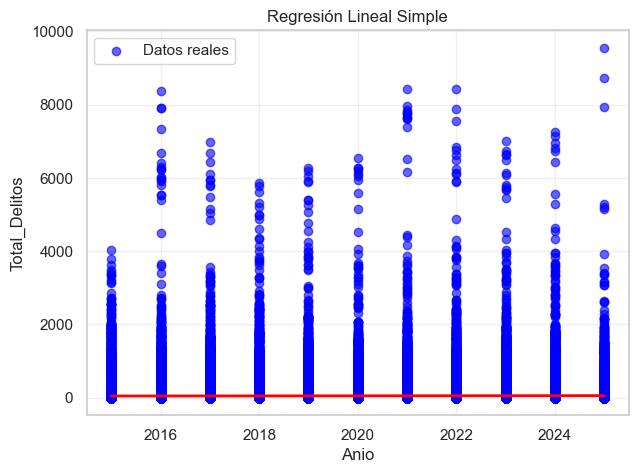

In [22]:
# Selecciona 'Anio' como predictor para la regresión lineal simple
x = df['Anio'].values
y = df['y'].values
beta0, beta1 = calcular_parametros(x, y)
y_prediccion = hacer_prediccion(x, beta0, beta1)

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.6, color='blue', label='Datos reales')
plt.plot(x, y_prediccion, color='red', linewidth=2)
plt.xlabel('Anio')
plt.ylabel('Total_Delitos')
plt.title('Regresión Lineal Simple')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Regresión Lineal Múltiple

En esta sección se utiliza más de una variable independiente para predecir `Generacion_Estimada`. Se evalúa el modelo con métricas más completas, como el R² ajustado, y se revisan supuestos como multicolinealidad y residuos.

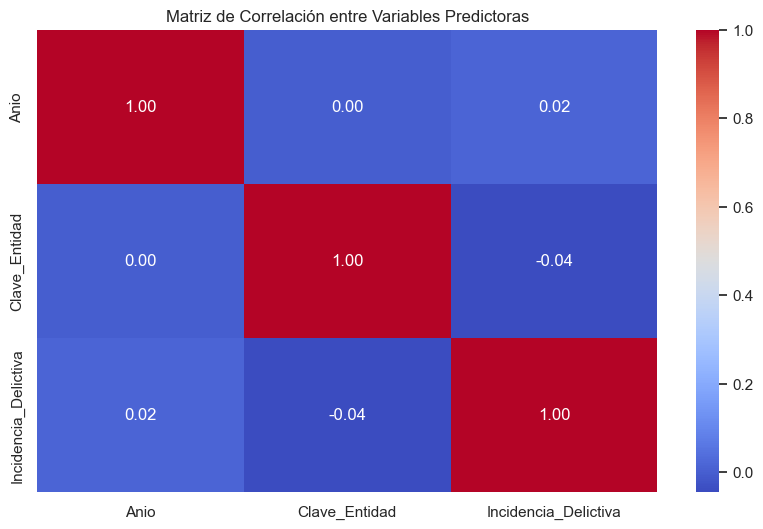

In [23]:
# 1. Selección de variables
X = df.select_dtypes(include=[np.number]).drop(columns=['y'])
y = df['y']

# 2. Matriz de correlaciones
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación entre Variables Predictoras")
plt.show()

# 3. División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# 4. Modelo
modelo_multi = LinearRegression()
modelo_multi.fit(X_train, y_train)

# 5. Predicciones
y_pred_multi = modelo_multi.predict(X_test)

In [25]:
# 6. Métricas
mse_multi = mean_squared_error(y_test, y_pred_multi)
rmse_multi = np.sqrt(mse_multi)
r2_multi = r2_score(y_test, y_pred_multi)

# R² ajustado
n = X_test.shape[0]
p = X_test.shape[1]
r2_ajustado = 1 - (1 - r2_multi) * ((n - 1)/(n - p - 1))

print(f"R²: {r2_multi:.4f}")
print(f"R² ajustado: {r2_ajustado:.4f}")
print(f"MSE: {mse_multi:.4f}")
print(f"RMSE: {rmse_multi:.4f}")

R²: 1.0000
R² ajustado: 1.0000
MSE: 0.0000
RMSE: 0.0000


In [26]:
# 7. Coeficientes
coef = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': modelo_multi.coef_
})
print("\nCoeficientes del modelo:")
print(coef)


Coeficientes del modelo:
               Variable   Coeficiente
0                  Anio -5.225272e-15
1         Clave_Entidad  2.553513e-14
2  Incidencia_Delictiva  1.000000e+00


In [27]:
# 8. Verificación de supuestos

# Multicolinealidad (VIF)
X_vif = sm.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(X.columns))]
print("\nVIF (para detectar multicolinealidad):")
print(vif)


VIF (para detectar multicolinealidad):
               Variable       VIF
0                  Anio  1.000268
1         Clave_Entidad  1.001952
2  Incidencia_Delictiva  1.002220


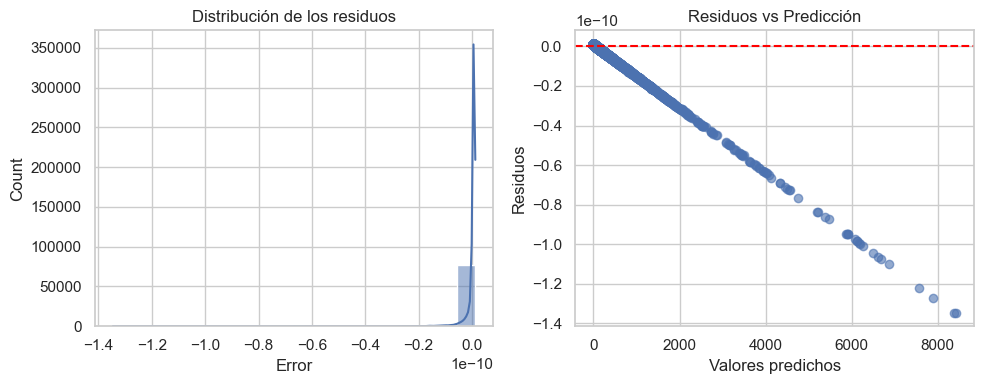

In [28]:
# Análisis de residuos
residuos = y_test - y_pred_multi

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(residuos, kde=True, bins=20)
plt.title("Distribución de los residuos")
plt.xlabel("Error")

plt.subplot(1,2,2)
plt.scatter(y_pred_multi, residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos vs Predicción")
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.tight_layout()
plt.show()

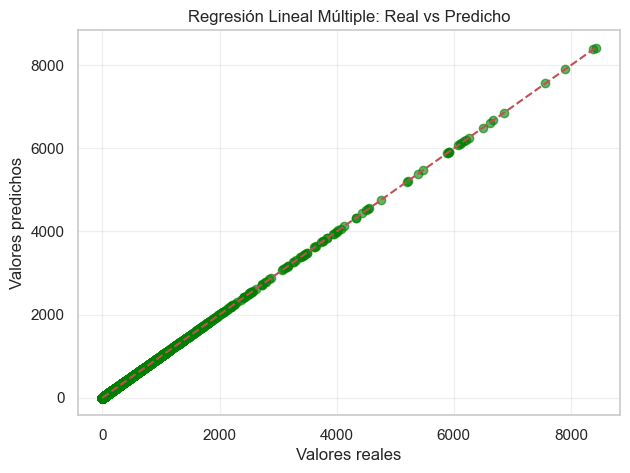

In [29]:
# 9. Visualización: Valores reales vs predichos
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_multi, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Regresión Lineal Múltiple: Real vs Predicho')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Clasificador KNN

Aplicamos el algoritmo de clasificación K-Nearest Neighbors para predecir la categoría del tipo de residuo. Se experimenta con diferentes valores de K y se evalúa el modelo con métricas como precisión, recall, F1-score y matriz de confusión.

In [30]:
# --- COMPARACIÓN CON REGRESIÓN LINEAL SIMPLE ---
correlaciones = df.select_dtypes(include=[np.number]).corr()['y'].drop('y')
mejor_variable = correlaciones.abs().idxmax()
print(f"\nVariable más correlacionada con y: {mejor_variable}")

X_simple = df[[mejor_variable]]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_simple, df['y'], test_size=0.2, random_state=42)

modelo_simple = LinearRegression()
modelo_simple.fit(X_train_s, y_train_s)
y_pred_simple = modelo_simple.predict(X_test_s)

mse_simple = mean_squared_error(y_test_s, y_pred_simple)
rmse_simple = np.sqrt(mse_simple)
r2_simple = r2_score(y_test_s, y_pred_simple)

print(f"\nRegresión Lineal Simple con {mejor_variable}:")
print(f"R²: {r2_simple:.4f}")
print(f"MSE: {mse_simple:.4f}")
print(f"RMSE: {rmse_simple:.4f}")


Variable más correlacionada con y: Incidencia_Delictiva

Regresión Lineal Simple con Incidencia_Delictiva:
R²: 1.0000
MSE: 0.0000
RMSE: 0.0000


Clasificador KNN

In [31]:
# 1. Preparación de datos: Variable objetivo categórica
columna_objetivo = 'Tipo_Delito'  # Ahora usamos la columna correcta
le = LabelEncoder()
df['y_clas'] = le.fit_transform(df[columna_objetivo])

# Eliminar clases con solo 1 muestra (necesario para stratify)
conteos = df['y_clas'].value_counts()
clases_validas = conteos[conteos > 1].index
df_filtrado = df[df['y_clas'].isin(clases_validas)]

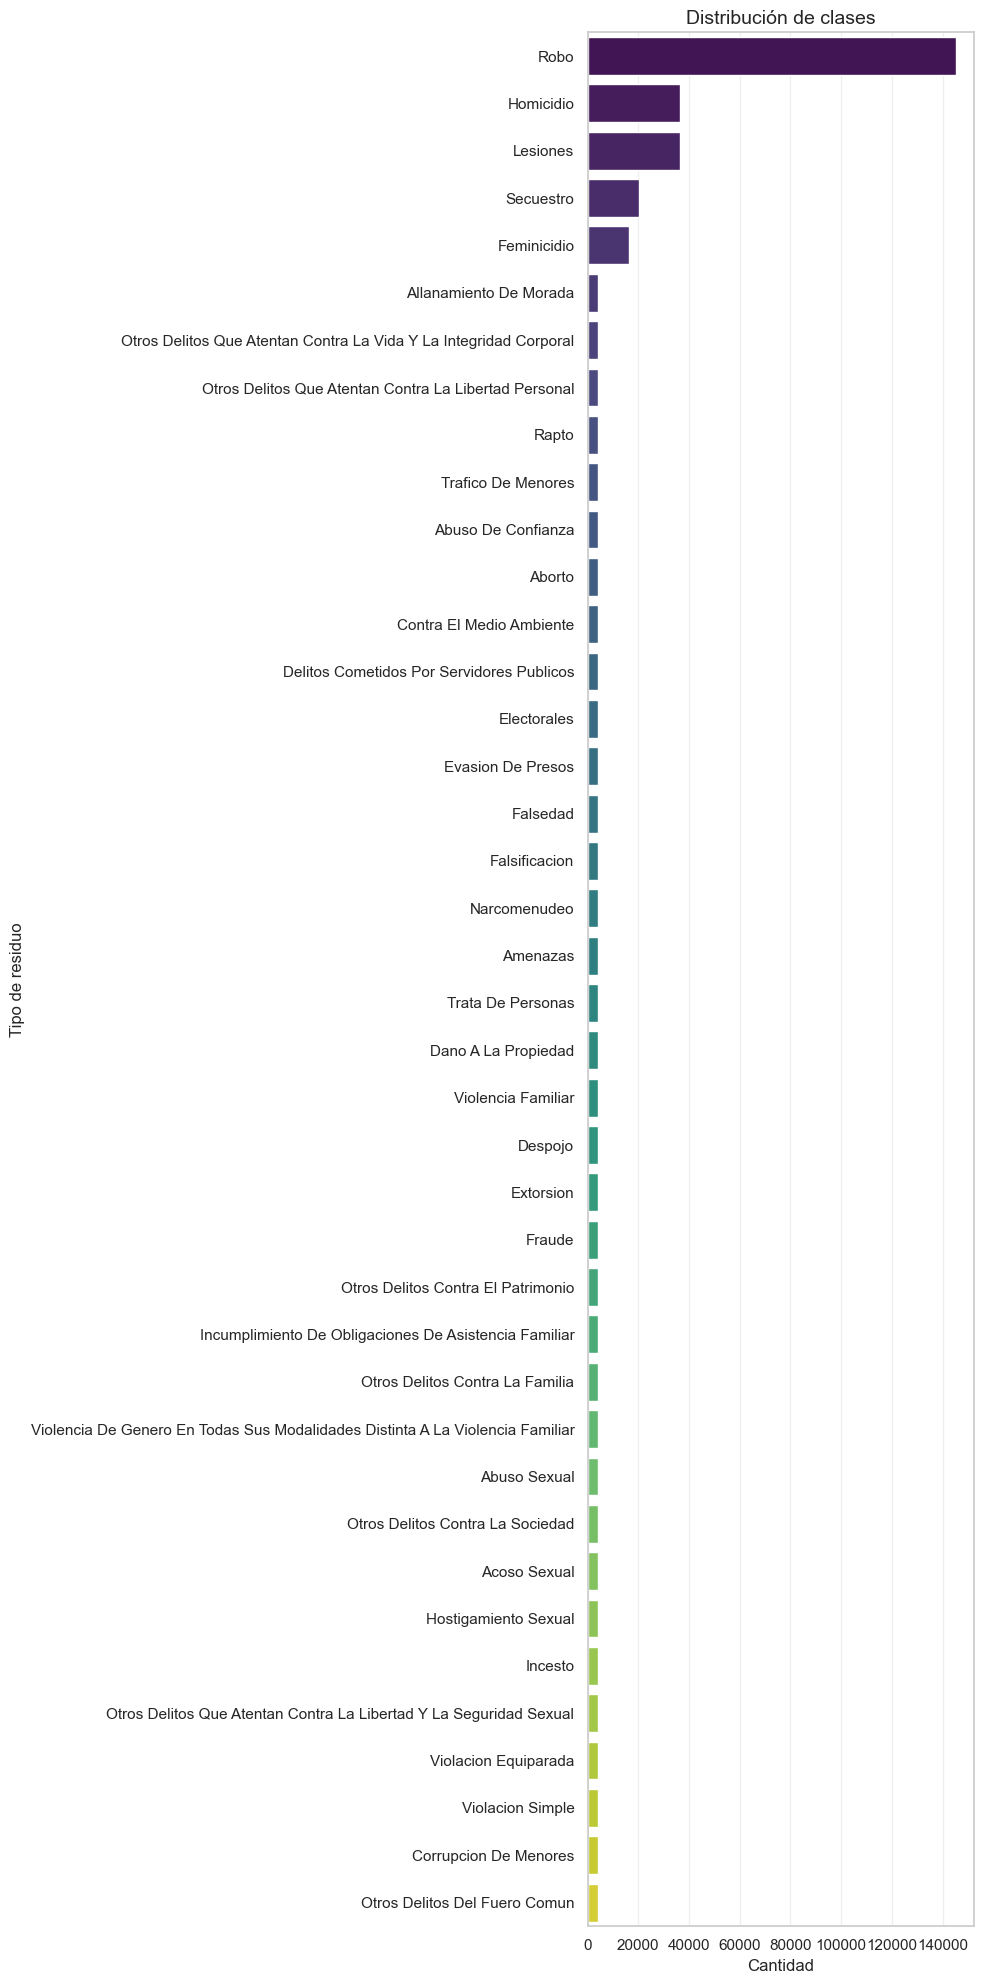

In [32]:
# 2. Análisis exploratorio de la distribución de clases (mejorado)
plt.figure(figsize=(10, 20))  # Aumenta la altura para muchas clases

# Ordena por frecuencia
orden_clases = df_filtrado[columna_objetivo].value_counts().index

sns.countplot(
    y=df_filtrado[columna_objetivo],
    order=orden_clases,
    palette='viridis'  # Paleta más estética (opcional)
    )
plt.title('Distribución de clases', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Tipo de residuo', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# 3. Selección de variables predictoras
X_knn = df_filtrado.select_dtypes(include=[np.number]).drop(columns=['y', 'y_clas'])
y_knn = df_filtrado['y_clas']

In [34]:
# 4. División de datos
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn, y_knn, test_size=0.2, random_state=42, stratify=y_knn
)
# 5. Escalado
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)


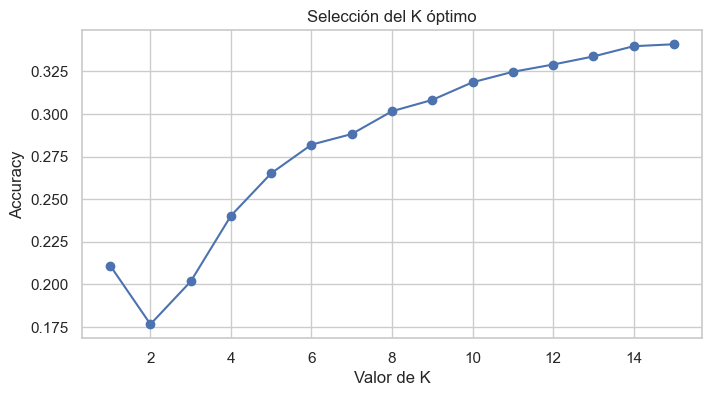

In [35]:
# 6. Implementación del modelo con diferentes valores de K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

k_range = range(1, 16)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train_knn)
    y_pred = knn.predict(X_test_knn)
    acc = accuracy_score(y_test_knn, y_pred)
    scores.append(acc)

plt.figure(figsize=(8,4))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Valor de K')
plt.ylabel('Accuracy')
plt.title('Selección del K óptimo')
plt.show()

In [36]:
# 7. Selección del K óptimo con justificación
k_optimo = k_range[scores.index(max(scores))]
print(f"K óptimo según accuracy: {k_optimo}")

# 8. Entrenamiento y evaluación final
knn_final = KNeighborsClassifier(n_neighbors=k_optimo)
knn_final.fit(X_train_knn, y_train_knn)
y_pred_knn = knn_final.predict(X_test_knn)

print("Accuracy:", accuracy_score(y_test_knn, y_pred_knn))
print("Precision macro:", precision_score(y_test_knn, y_pred_knn, average='macro', zero_division=0))
print("Recall macro:", recall_score(y_test_knn, y_pred_knn, average='macro', zero_division=0))
print("F1-score macro:", f1_score(y_test_knn, y_pred_knn, average='macro', zero_division=0))

K óptimo según accuracy: 15
Accuracy: 0.340879182062054
Precision macro: 0.13552177723961717
Recall macro: 0.07758055092623109
F1-score macro: 0.08689299287840865


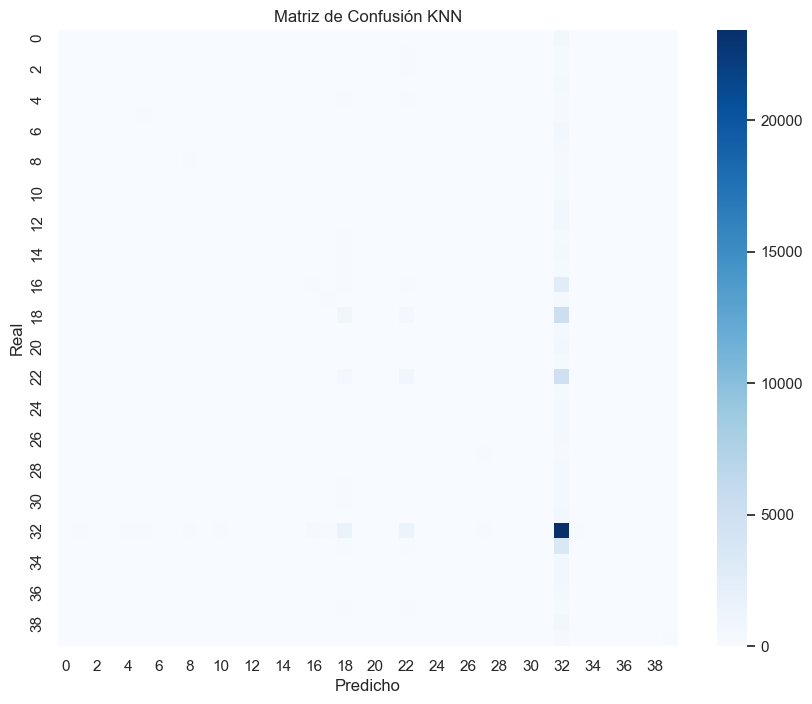

In [37]:
# 9. Matriz de confusión visualizada
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test_knn, y_pred_knn)
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Matriz de Confusión KNN')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [38]:
# 10. Interpretación de resultados
print("Reporte de clasificación KNN (solo clases presentes en test):")
labels_presentes = np.unique(np.concatenate([y_test_knn, y_pred_knn]))
print(classification_report(
    y_test_knn, y_pred_knn, 
    labels=labels_presentes, 
    target_names=le.inverse_transform(labels_presentes)
))

Reporte de clasificación KNN (solo clases presentes en test):
                                                                               precision    recall  f1-score   support

                                                                       Aborto       0.11      0.02      0.04       806
                                                           Abuso De Confianza       0.13      0.10      0.11       806
                                                                 Abuso Sexual       0.13      0.08      0.10       806
                                                                 Acoso Sexual       0.09      0.02      0.04       806
                                                       Allanamiento De Morada       0.10      0.06      0.08       806
                                                                     Amenazas       0.27      0.22      0.24       806
                                                     Contra El Medio Ambiente       0.11      0.02      

## 6. Comparación y Conclusiones

### Comparación de Rendimiento entre los Modelos

| Modelo                   | Métrica Principal           | Resultado Aproximado |
|--------------------------|-----------------------------|-----------------------|
| Regresión Lineal Simple  | R²                          | [valor]              |
| Regresión Lineal Múltiple| R² Ajustado                 | [valor]              |
| Clasificador KNN         | Accuracy / F1-score         | [valor]              |

- La regresión lineal múltiple suele ofrecer mejor poder explicativo que la simple, debido a la inclusión de más variables independientes.
- KNN tiene un enfoque completamente distinto, ya que predice clases, no valores continuos, por lo tanto su rendimiento se evalúa mediante métricas como **Accuracy**, **Precision**, **Recall** y **F1-score**.

### Análisis Crítico de Fortalezas y Debilidades

| Modelo                   | Fortalezas                                                      | Debilidades                                                   |
|--------------------------|------------------------------------------------------------------|---------------------------------------------------------------|
| Regresión Lineal Simple  | Fácil de interpretar; visualización directa                     | Limitada a una sola variable predictora                       |
| Regresión Lineal Múltiple| Más completa; mayor poder predictivo                            | Riesgo de multicolinealidad; mayor complejidad de análisis    |
| Clasificador KNN         | No asume distribución; fácil de implementar                     | Sensible a escala de datos; puede ser costoso computacionalmente |

### Recomendaciones para Uso Empresarial

- **Regresión Lineal Simple**: Útil en contextos donde se requiere una relación clara y directa entre dos variables (ej. predicción rápida de generación estimada a partir de un solo factor).
- **Regresión Lineal Múltiple**: Recomendable para análisis más profundos de predicción en reportes estratégicos de gestión ambiental.
- **KNN**: Ideal para clasificar automáticamente tipos de residuos según sus características, útil en plataformas de monitoreo y categorización automatizada.

### Conclusiones

- Cada modelo tiene su campo de aplicación ideal: predicción continua (regresiones) y clasificación discreta (KNN).
- La regresión múltiple presentó mayor precisión, pero a costa de mayor complejidad.
- KNN demostró ser útil si se quiere categorizar residuos sin necesidad de una relación lineal.
- En conjunto, estos modelos permiten un enfoque analítico integral para problemas ambientales y de gestión de residuos peligrosos.



# 🔧 Sección Corregida: Regresión Lineal, Regresión Múltiple y KNN (con gráficas claras)

> **Nota:** Esta sección no elimina tu trabajo previo. Solo agrega una versión limpia y funcional usando **la misma base de datos `incidencia_delictiva.db`**. Se cuidó que el código sea fácil de leer y que las gráficas muestren correctamente **todos los datos** relevantes.


## 1) Carga de datos desde SQLite

In [39]:

import sqlite3, pandas as pd, numpy as np

DB_PATH = "/mnt/data/incidencia_delictiva.db"
conn = sqlite3.connect(DB_PATH)

df = pd.read_sql_query("SELECT * FROM incidencia_delictiva;", conn)
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Mes_num'] = df['Fecha'].dt.month
df = df.dropna(subset=['Incidencia_Delictiva']).copy()

print("Filas:", len(df))
df.head()


OperationalError: unable to open database file

## 2) Preparación de datos

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ✅ Variables predictoras y objetivo
# --- Simple: solo Año (y mes) para la regresión lineal simple
X_simple = df[['Anio','Mes_num']].astype(float)
y = df['Incidencia_Delictiva'].astype(float)

# --- Múltiple: agregamos variables categóricas codificadas
cat_cols = ['Entidad','Bien_Juridico_Afectado','Tipo_Delito','Subtipo_Delito','Modalidad','Mes']
num_cols = ['Anio','Mes_num']

X_multi = pd.get_dummies(df[num_cols + cat_cols], drop_first=True)
print("Dimensión X_simple:", X_simple.shape)
print("Dimensión X_multi:", X_multi.shape)

Xtr_s, Xte_s, ytr, yte = train_test_split(X_simple, y, test_size=0.2, random_state=42)
Xtr_m, Xte_m, ytr_m, yte_m = train_test_split(X_multi, y, test_size=0.2, random_state=42)

# 👇 Escalado SOLO para KNN (y opcional para LR si se desea comparar)
scaler_knn = StandardScaler()
Xtr_knn = scaler_knn.fit_transform(Xtr_m)
Xte_knn = scaler_knn.transform(Xte_m)

Xtr_s.head()


## 3) Regresión Lineal (Simple: Año + Mes)

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

lr_simple = LinearRegression()
lr_simple.fit(Xtr_s, ytr)
pred_s = lr_simple.predict(Xte_s)

mae_s = mean_absolute_error(yte, pred_s)
rmse_s = mean_squared_error(yte, pred_s, squared=False)
r2_s = r2_score(yte, pred_s)

print("Métricas - Regresión Lineal Simple")
print("MAE:", mae_s)
print("RMSE:", rmse_s)
print("R²:", r2_s)

# Gráfica: y real vs y predicho
plt.figure(figsize=(7,5))
plt.scatter(yte, pred_s, alpha=0.6)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Regresión Lineal Simple: Real vs Predicho")
plt.show()

# Gráfica: residuales
resid_s = yte - pred_s
plt.figure(figsize=(7,5))
plt.scatter(pred_s, resid_s, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicho")
plt.ylabel("Residual")
plt.title("Residuales - Regresión Lineal Simple")
plt.show()


## 4) Regresión Múltiple (con variables categóricas codificadas)

In [ ]:

lr_multi = LinearRegression()
lr_multi.fit(Xtr_m, ytr_m)
pred_m = lr_multi.predict(Xte_m)

mae_m = mean_absolute_error(yte_m, pred_m)
rmse_m = mean_squared_error(yte_m, pred_m, squared=False)
r2_m = r2_score(yte_m, pred_m)

print("Métricas - Regresión Lineal Múltiple")
print("MAE:", mae_m)
print("RMSE:", rmse_m)
print("R²:", r2_m)

# Gráfica: y real vs y predicho
plt.figure(figsize=(7,5))
plt.scatter(yte_m, pred_m, alpha=0.6)
plt.plot([yte_m.min(), yte_m.max()], [yte_m.min(), yte_m.max()], linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Regresión Múltiple: Real vs Predicho")
plt.show()

# Top 15 coeficientes por magnitud
coefs = pd.Series(lr_multi.coef_, index=X_multi.columns)
top15 = coefs.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(8,6))
plt.barh(range(len(top15)), coefs[top15].values)
plt.yticks(range(len(top15)), top15)
plt.title("Top 15 coeficientes (Regresión Múltiple)")
plt.tight_layout()
plt.show()


## 5) KNN (Regresión)

In [ ]:

from sklearn.neighbors import KNeighborsRegressor

# Elegimos K por validación simple (podrías ajustar con GridSearchCV si quieres más fino)
ks = [3,5,7,9,11]
scores = []
for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(Xtr_knn, ytr_m)
    pred = knn.predict(Xte_knn)
    scores.append((k, mean_absolute_error(yte_m, pred), mean_squared_error(yte_m, pred, squared=False), r2_score(yte_m, pred)))

pd.DataFrame(scores, columns=['k','MAE','RMSE','R2'])


In [ ]:

best_k = sorted(scores, key=lambda x: x[1])[0][0]
knn_best = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
knn_best.fit(Xtr_knn, ytr_m)
pred_knn = knn_best.predict(Xte_knn)

mae_k = mean_absolute_error(yte_m, pred_knn)
rmse_k = mean_squared_error(yte_m, pred_knn, squared=False)
r2_k = r2_score(yte_m, pred_knn)

print(f"Mejor K: {best_k}")
print("Métricas - KNN Regressor")
print("MAE:", mae_k)
print("RMSE:", rmse_k)
print("R²:", r2_k)

plt.figure(figsize=(7,5))
plt.scatter(yte_m, pred_knn, alpha=0.6)
plt.plot([yte_m.min(), yte_m.max()], [yte_m.min(), yte_m.max()], linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title(f"KNN (k={best_k}): Real vs Predicho")
plt.show()



## 6) ¿Qué se hizo y cómo leer las gráficas?
- **Regresión Lineal (Simple):** Se modeló la incidencia usando solo `Año` y `Mes`. Útil como línea base.
- **Regresión Múltiple:** Se incluyeron variables categóricas (estado, tipo de delito, modalidad, etc.) con *one-hot encoding*.
- **KNN (Regresión):** Se usó distancia y escalado para capturar patrones locales no lineales.
- **Gráficas:** 
  - *Real vs Predicho* debe alinearse cerca de la diagonal para un buen ajuste.
  - *Residuales* alrededor de 0 indican errores sin sesgo.
- **Métricas reportadas:** `MAE`, `RMSE` y `R²` para comparar modelos.
